In [1]:
# uncomment this if you want to use interactive plot (only works in Jupyter not works in VScode)
# %matplotlib widget

import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [2]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

D:\anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Calculating spatial neighbor graph ...
The graph contains 38617 edges, 3777 cells.
10.224252051893037 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 45028 edges, 4352 cells.
10.346507352941176 neighbors per cell on average.
Use DPCA feature to format graph


D:\anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
D:\anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
D:\anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
D:\anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!
Choose GPU:0 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 4.08
dataset1: 7 cell types; dataset2: 7 cell types; 
                    Total :8 celltypes; Overlap: 6 cell types 
                    Not overlap :[['Endothelial', 'Plasma']]
Subsample 300 cell pairs from 4352


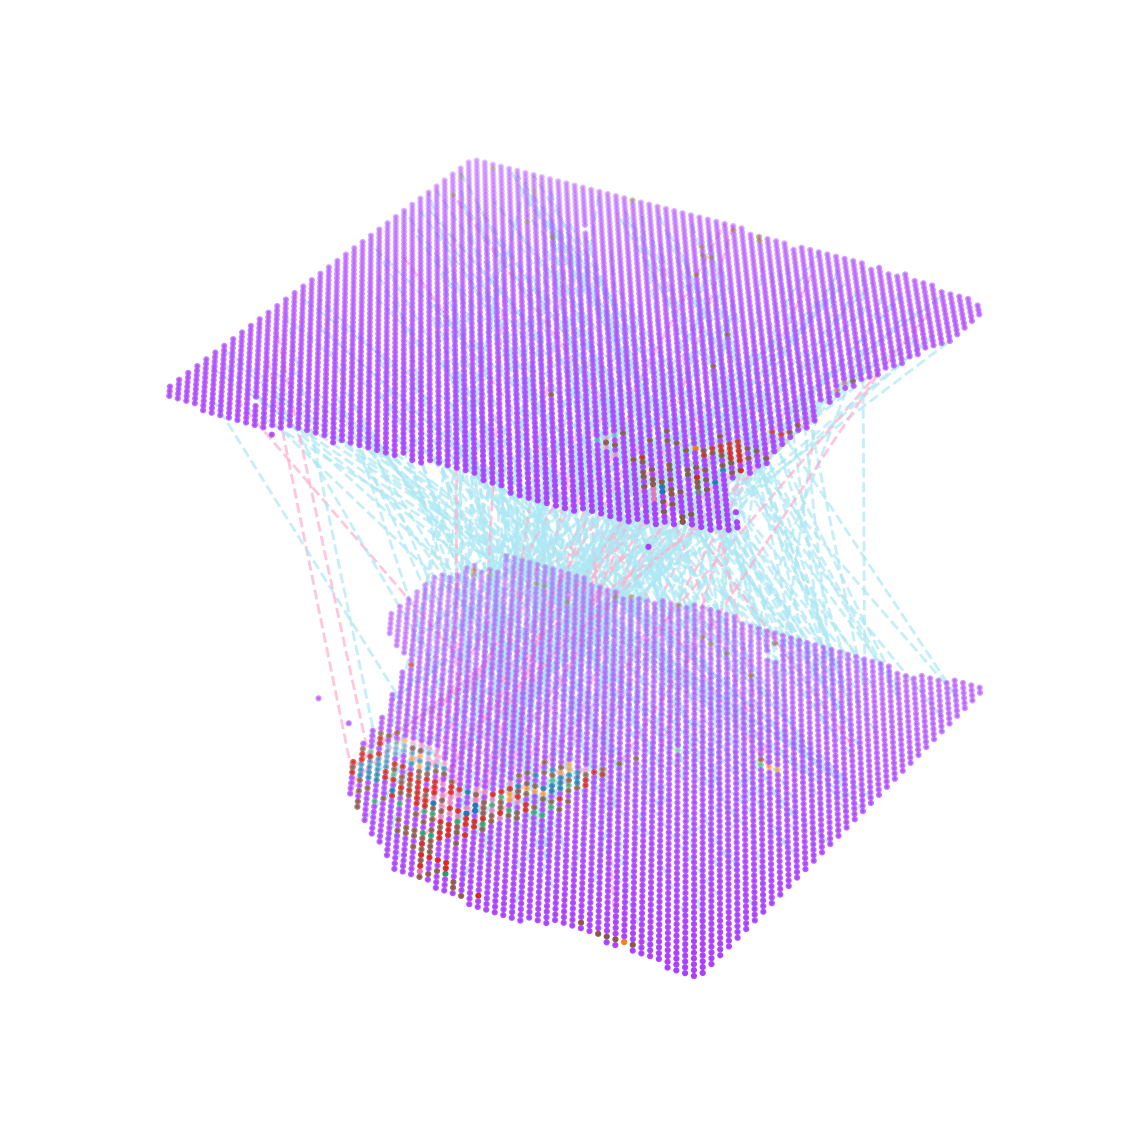

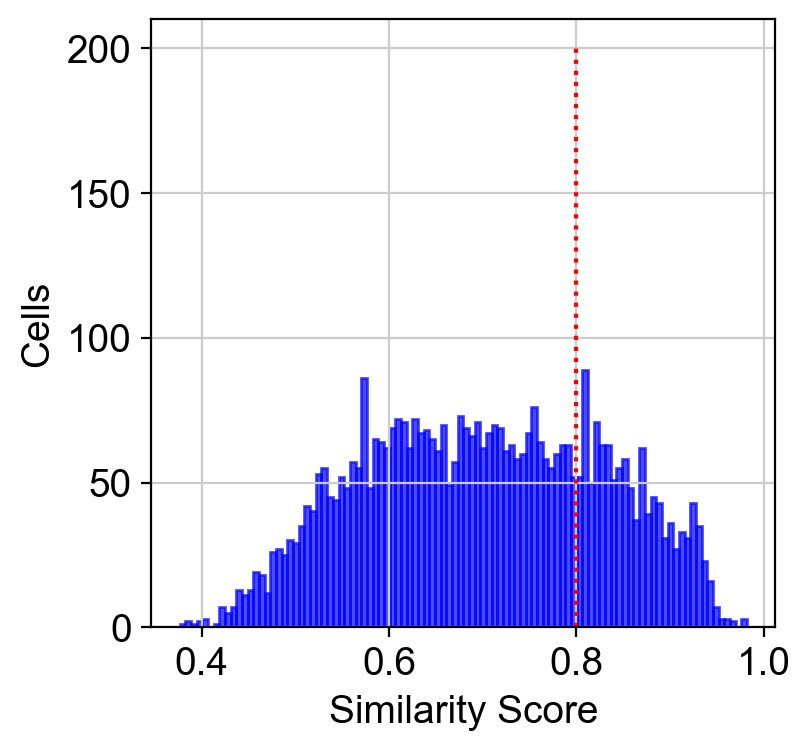

In [3]:
# datasets = ["HCC-5A","HCC-5B"]
# datasets = ["HCC-5A","HCC-5C"]
# datasets = ["HCC-5A","HCC-5D"]
# datasets = ["HCC-5B","HCC-5C"]
# datasets = ["HCC-5B","HCC-5D"]
datasets = ["HCC-5C","HCC-5D"]
experiment_name = 'LICA_C_D'
input_dir = 'G:/dataset/LICA/input/'
output_dir = 'G:/dataset/LICA/output/SLAT/'

adata_list = []

for dataset in datasets:
    adata = sc.read_visium(input_dir + dataset)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata_label = pd.read_csv(input_dir + dataset + '/' + 'truth.csv', index_col=0)
    adata.obs['batch'] = adata_label['batch']
    adata.obs['annotation'] = adata_label['celltype']
    adata_list.append(adata)

Cal_Spatial_Net(adata_list[0], k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata_list[1], k_cutoff=10, model='KNN')

edges, features = load_anndatas([adata_list[0], adata_list[1]], feature='DPCA', check_order=False)

embd0, embd1, time = run_SLAT(features, edges)

best, index, distance = spatial_match(features, adatas=[adata_list[0],adata_list[1]], reorder=False)

adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_list[0].obsm['spatial'][:,0],
                        'y': adata_list[0].obsm['spatial'][:,1],
                        'celltype': adata_list[0].obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_list[1].obsm['spatial'][:,0],
                        'y': adata_list[1].obsm['spatial'][:,1],
                        'celltype': adata_list[1].obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

multi_align = match_3D_multi(adata1_df, adata2_df, matching,meta='celltype',
                            scale_coordinate=True, subsample_size=300)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

%matplotlib inline
hist(best_match, cut=0.8)

In [4]:
adata1_df.to_csv(output_dir + 'SLAT_' + experiment_name + '_' + datasets[0] + '.csv')
adata2_df.to_csv(output_dir + 'SLAT_' + experiment_name + '_' + datasets[1] + '.csv')